<a href="https://colab.research.google.com/github/mbido/L3-Automaton-Library/blob/main/Test_Performances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vérification des résultats de l'étude : "Comparing Classifiers Performance under Differential Privacy"


##1. Import des datasets

Utilisation des mêmes datasets : Adult, Mushroom, Nursery, Congres-
sional Voting, SPECT Heart, et Skin.

In [ ]:
!pip install ucimlrepo

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from time import time
from scipy import optimize
from sklearn.model_selection import KFold


from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)
mushroom = fetch_ucirepo(id=73)
nursery = fetch_ucirepo(id=76)
congressional_voting_records = fetch_ucirepo(id=105)
spect_heart = fetch_ucirepo(id=95)
skin_segmentation = fetch_ucirepo(id=229)

# data (as pandas dataframes)
datasets = {
    "adult": {
        "X": adult.data.features,
        "y": adult.data.targets
    },
    "mushroom": {
        "X": mushroom.data.features,
        "y": mushroom.data.targets
    },
    "nursery": {
        "X": nursery.data.features,
        "y": nursery.data.targets
    },
    "congressional_voting_records": {
        "X": congressional_voting_records.data.features,
        "y": congressional_voting_records.data.targets
    },
    "spect_heart": {
        "X": spect_heart.data.features,
        "y": spect_heart.data.targets
    },
    "skin_segmentation": {
        "X": skin_segmentation.data.features,
        "y": skin_segmentation.data.targets
    }
}

##2. Code source issue du github : https://github.com/jeroenkivits/seminar

In [ ]:
"""
SVM class that contains all function needed to train a SVM classifier,
private and non-private.
"""
class SVM:
    def __init__(self, private, labda, h):
        self.private = private
        self.labda = labda
        self.h = h

    """"
    Function that trains the SVM classifier.
    """
    def fit(self, training_data, epsilon_p):
        # Split dataframe between labels and d
        df_train_y = training_data["dependent"]
        df_train_x = training_data.drop(columns="dependent")

        train_x = df_train_x.values
        train_y = df_train_y.values


        self.n = train_x.shape[0]
        self.features = train_x.shape[1]

        # Create initial guess for optimization
        f0 = np.ones(self.features)

        if self.private:
            epsilon_p_prime = epsilon_p-np.log(1+((1/self.h)/(self.n*self.labda))+(
                        ((1/(2*self.h))**2)/((self.n**2)*(self.labda**2))))

            # check which delta should be used
            if epsilon_p_prime > 0:
                delta = 0
            else:
                delta = ((1/(2*self.h))/(self.n*(np.exp(epsilon_p/4)-1)))-self.labda
                epsilon_p_prime = epsilon_p/2

            # create noise according to epsilon_p_prime
            noise = self.noise_diffpriv(self.features, epsilon_p_prime)

            # optimize function func with BFGS method
            sol = optimize.fmin_bfgs(self.func, f0, args=(train_x, train_y, noise), disp=False)
            f = sol

            self.f = f + (delta*np.linalg.norm(f)**2)/2

        else:
            # create vector with zeros to pass as noise
            noise = np.zeros(self.features)

            # optimize function func with BFGS method
            sol = optimize.fmin_bfgs(self.func, f0, args=(train_x, train_y, noise), disp=False)
            self.f = sol


    """"
    Callback function available to keep tabs on the optimization process,
    only necessary to add callback=call to the scipy optimize function.
    optimize.fmin_bfgs(self.func, f0, args=(train_x, train_y, noise), disp=False, callback=call)
    """
    def call(self, data):
        print('[Iteration finished]')

    """"
    This function calculates regularized emperical loss according to
    """
    def func(self, f, train_x, train_y, noise):
        # calculate position of training data to predictor f
        z = np.dot(f, train_x.T) * train_y


        conditions = [
            z > 1 + self.h,
            np.abs(1 - z) <= self.h,
            z < 1 - self.h
        ]

        choices = [
            0,
            (1 / 4 * self.h) * (1 + self.h - z),
            1 - z
        ]

        loss = np.select(conditions, choices)

        # return regularized emperical loss, noise is added in this step
        # noise set to zero will not be added to the regularized emperical loss, since it renders the 1/n * Transpose(b) . f zero
        return np.mean(loss) + (self.labda / 2 * (np.linalg.norm(f) ** 2)) + ((1 / self.n) * np.dot(np.transpose(noise), f))

    """
    This function predicts the position of the test data relative to the predictor vector f
    and returns the error rate.
    """
    def evaluate(self, test_data):
        df_test_y = test_data["dependent"]
        df_test_x = test_data.drop(columns="dependent")

        test_x = df_test_x.values
        test_y = df_test_y.values

        errors = 0
        for idx, datapoint in enumerate(test_x):
            pred = np.sign(np.dot(np.transpose(self.f), datapoint))

            if pred != test_y[idx]:
                errors += 1

        return errors/test_x.shape[0]

    """"
    Construct noise with exponential distribution with beta = 2/epsilon_p_prime
    """
    def noise_diffpriv(self, dim, epsilon_p_prime):
        b = np.random.exponential(2/epsilon_p_prime, dim)
        return b

## 3. Préparation des données et entrainement sur chaque epsilone

Dans cette expérience, nous reproduisons l’évaluation du classificateur SVM sous confidentialité différentielle (ε-DP) sur six datasets issus de l’UCI Machine Learning Repository : Adult, Mushroom, Nursery, SPECT, Congressional Voting Records et Skin Segmentation.

Pour chaque dataset, les attributs catégoriels sont encodés en entiers de manière aléatoire, et les labels sont convertis en {-1, +1} pour correspondre au format attendu par le SVM. Aucun prétraitement de normalisation n’est appliqué afin de rester fidèle au modèle original.

Nous effectuons ensuite une validation croisée à 10 folds pour chaque valeur d’ε sélectionnée (ε = 1e-11, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 3, 5, 10) et calculons l’accuracy moyenne et l’écart-type.

Contrairement à l’expérience originale, qui répète chaque cross-validation 100 fois pour réduire la variance introduite par le bruit ε-DP et le partitionnement des folds, nous avons choisi de ne réaliser qu’une seule répétition pour chaque 10-fold CV. Principalement pour des raisons de temps d'éxecution (20 minutes pour une seule run).

In [ ]:
epsilons = [1e-11, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 3, 5, 10]

np.random.seed(42)

# Résultats stockés : results[dataset][epsilon] = {"mean_accuracy", "std_accuracy", "time"}
results = {}

for dataset_name, data in datasets.items():
    print(f"\n==============================")
    print(f"Dataset : {dataset_name}")
    print(f"==============================")

    X = data["X"].copy()
    y = data["y"].copy()

    # Construction du DataFrame

    df = X.copy()
    df["dependent"] = y.values.ravel()

    # Nettoyage
    df.replace("?", np.nan, inplace=True)
    df.dropna(inplace=True)

    # Encodage catégoriel aléatoire
    random_encoders = {}
    for col in df.columns:
        if df[col].dtype == "object":
            unique_vals = df[col].unique()
            random_values = np.random.permutation(len(unique_vals))
            mapping = dict(zip(unique_vals, random_values))
            random_encoders[col] = mapping
            df[col] = df[col].map(mapping)

    # Labels en {-1, +1}
    df["dependent"] = df["dependent"].apply(lambda x: 1 if x == 1 else -1)

    df_scaled = df.copy()


     # pas de normalisation

    # Cross-validation pour toutes les valeurs d'epsilon
    dataset_results = {}

    for eps in epsilons:
        print(f"\nÉpsilon = {eps}")
        fold_accuracies = []

        # 10-fold CV
        kf = KFold(n_splits=10, shuffle=True, random_state=42)

        for train_idx, test_idx in kf.split(df_scaled):
            train_df = df_scaled.iloc[train_idx]
            test_df = df_scaled.iloc[test_idx]

            svm = SVM(private=True, labda=0.01, h=0.1)
            svm.fit(train_df, epsilon_p=eps)

            error = svm.evaluate(test_df)
            accuracy = 1 - error
            fold_accuracies.append(accuracy)

        mean_acc = np.mean(fold_accuracies)
        std_acc = np.std(fold_accuracies)

        dataset_results[eps] = {
            "mean_accuracy": mean_acc,
            "std_accuracy": std_acc
        }

        print(f"  Accuracy moyenne : {mean_acc:.4f}")
        print(f"  Écart-type       : {std_acc:.4f}")

    results[dataset_name] = dataset_results



Dataset : adult

Épsilon = 1e-11
  Accuracy moyenne : 0.5010
  Écart-type       : 0.0075

Épsilon = 0.001
  Accuracy moyenne : 0.5010
  Écart-type       : 0.0075

Épsilon = 0.005
  Accuracy moyenne : 0.5010
  Écart-type       : 0.0075

Épsilon = 0.01
  Accuracy moyenne : 0.5010
  Écart-type       : 0.0075

Épsilon = 0.05
  Accuracy moyenne : 0.6300
  Écart-type       : 0.0067

Épsilon = 0.1
  Accuracy moyenne : 0.6288
  Écart-type       : 0.0060

Épsilon = 0.25
  Accuracy moyenne : 0.6302
  Écart-type       : 0.0069

Épsilon = 0.5
  Accuracy moyenne : 0.6305
  Écart-type       : 0.0065

Épsilon = 0.75
  Accuracy moyenne : 0.6306
  Écart-type       : 0.0069

Épsilon = 1
  Accuracy moyenne : 0.6309
  Écart-type       : 0.0069

Épsilon = 3
  Accuracy moyenne : 0.6299
  Écart-type       : 0.0064

Épsilon = 5
  Accuracy moyenne : 0.6298
  Écart-type       : 0.0063

Épsilon = 10
  Accuracy moyenne : 0.6255
  Écart-type       : 0.0129

Dataset : mushroom

Épsilon = 1e-11
  Accuracy moyenne :

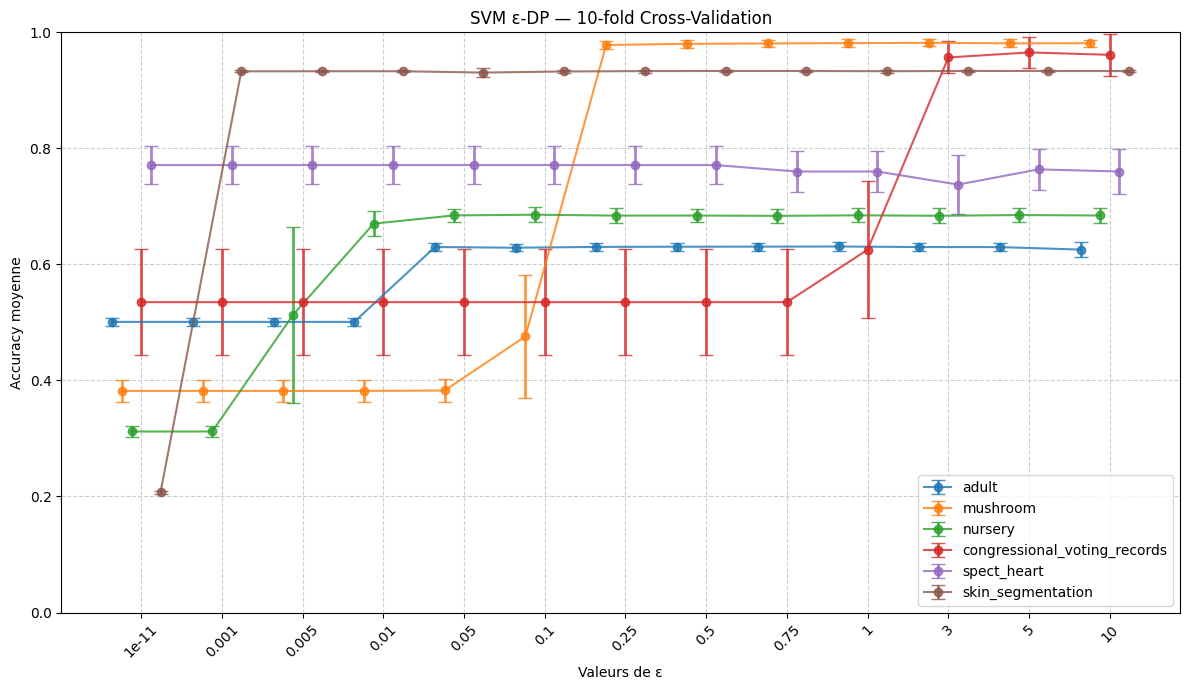

In [ ]:
plt.figure(figsize=(12, 7))
x_pos = np.arange(len(epsilons))
width = 0.12

max_std = 0.3  # limiter les barres pour lisibilité

for i, (dataset_name, dataset_results) in enumerate(results.items()):
    mean_accuracies = [dataset_results[eps]["mean_accuracy"] for eps in epsilons]
    std_accuracies = [min(dataset_results[eps]["std_accuracy"], max_std) for eps in epsilons]

    x_offset = x_pos + (i - len(results)/2) * width

    plt.errorbar(
        x_offset,
        mean_accuracies,
        yerr=std_accuracies,
        fmt='o-',
        capsize=5,
        elinewidth=2,
        markersize=6,
        alpha=0.8,
        label=dataset_name
    )

plt.xticks(x_pos, epsilons, rotation=45)
plt.yticks(np.arange(0, 1.01, 0.2))
plt.ylim(0, 1)

plt.xlabel("Valeurs de ε")
plt.ylabel("Accuracy moyenne")
plt.title("SVM ε-DP — 10-fold Cross-Validation")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Tableau des résultats

summary = []

for dataset_name, dataset_results in results.items():
    # Accuracy moyenne sur tous les epsilon
    mean_accuracy = np.mean([dataset_results[eps]["mean_accuracy"] for eps in epsilons])
    summary.append({
        "Dataset": dataset_name,
        "Mean Accuracy": mean_accuracy
    })

# Calcul de l'average totale
average_total = np.mean([row["Mean Accuracy"] for row in summary])
summary.append({
    "Dataset": "Average",
    "Mean Accuracy": average_total
})

# Créer DataFrame
summary_df = pd.DataFrame(summary)

# Affichage
print("\n===== Résumé des accuracies moyennes =====")
print(summary_df)



===== Résumé des accuracies moyennes =====
                        Dataset  Mean Accuracy
0                         adult       0.590004
1                      mushroom       0.711649
2                       nursery       0.612874
3  congressional_voting_records       0.640259
4                   spect_heart       0.765505
5             skin_segmentation       0.877102
6                       Average       0.699565


##4. Conclusion

###4.1

Les résultats du papier / référence (tableau comparatif) :

| Classifier                | Adult  | Mushroom | Nursery | SPECT  | Congress | Skin   | Average |
| ------------------------- | ------ | -------- | ------- | ------ | -------- | ------ | ------- |
| Accuracy (no privacy)     | 0.8288 | 0.9990   | 0.9747  | 0.6995 | 0.4139   | 0.7914 | 0.7846  |
| Average accuracy (ε-DP)   | 0.8131 | 0.8892   | 0.8794  | 0.5014 | 0.2454   | 0.7918 | 0.6867  |
| Ratio (ε-DP / no privacy) | 0.9811 | 0.8901   | 0.9022  | 0.7167 | 0.5929   | 1.0001 | 0.8473  |


###4.2

Les résultats obtenus avec le SVM ε-DP sur les six datasets montrent un impact significatif de la confidentialité différentielle sur la performance, particulièrement pour les très petits ε. Les datasets Adult, Mushroom et Nursery sont fortement affectés par le bruit ajouté, ce qui se traduit par une accuracy moyenne plus faible que celle reportée dans la référence. Pour certains datasets comme SPECT et Congressional Voting Records, la variance due au bruit DP et à l’encodage aléatoire conduit à des performances supérieures aux valeurs de référence, illustrant la sensibilité des SVM ε-DP aux conditions expérimentales et au prétraitement des données. Globalement, l’accuracy moyenne sur tous les datasets est proche de celle du papier (≈0.70 vs 0.69), mais les écarts dataset par dataset soulignent l’influence combinée du paramétrage de ε, du prétraitement et de la stabilité des runs.